In [1]:
import os
import time
import ollama
import pandas as pd

In [2]:
def messages_from_prompt(prompt):
    messages = []
    with open(f"prompts/{prompt}", "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    for line in lines:
        role = line.split(" ")[0]
        content = line[len(role)+1:]
        messages.append({"role": role, "content": content})
    return messages

In [3]:
# for all prompts evaluate the model

# all the text files in the prompts directory
prompts = [f for f in os.listdir("prompts") if f.endswith(".txt")]
models = ["openchat", "mistral", "llama2", "gemma", "openhermes"]

time_df = pd.DataFrame(columns=["model", "prompt", "time_per_char", "time_init", "time_total"])

for model in models:
    print(f"Model: {model}")
    ollama.chat(
        model=model,
        messages=[],
        stream=False
    )
    for prompt in prompts:
        print(f"Prompt: {prompt}")
        messages = messages_from_prompt(prompt)
        response = ""
        first_chunk = True
        start = time.time()
        stream = ollama.chat(
            model=model,
            messages=messages,
            stream=True
        )
        for chunk in stream:
            if first_chunk:
                before_stream = time.time()
                first_chunk = False
            response += chunk['message']['content']
            print(response, end="\r")
        end = time.time()
        time_df = pd.concat([time_df, pd.DataFrame([{
            "model": model,
            "prompt": prompt,
            "time_per_char": (end - before_stream) / len(response),
            "time_init": before_stream - start,
            "time_total": end - start
        }])])
        print(f"Time: {end - start}")
        with open(f"responses/{model}_chat_{prompt}", "w", encoding="utf-8") as f:
            f.write(response)
        time.sleep(1)

# write the time df to a file
with open("time_df.csv", "w") as f:
    time_df.to_csv(f, index=False)

Model: openchat
Prompt: prompt_1.txt
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines de la Systémique :
Pacte Novation est un groupe composé de plusieurs filiales spécialisées dans les domaines d

C:\Users\echriston\AppData\Local\Temp\ipykernel_9748\4217288979.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_df = pd.concat([time_df, pd.DataFrame([{


Prompt: prompt_2.txt
 Moustique : Le Moustique et la Chrysalide
 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalide

 Moustique : Le Moustique et la Chrysalidevol

 Moustique : Le Moustique et la Chrysalidevoler

 Moustique : Le Moustique et la Chrysalidevoler dans

 Moustique : Le Moustique et la Chrysalidevoler dans les

 Moustique : Le Moustique et la Chrysalidevoler dans les j

 Moustique : Le Moustique et la Chrysalidevoler dans les jard

 Moustique : Le Moustique et la C

## Analysis

### Time

In [4]:
# read csv file

time_df = pd.read_csv("time_df.csv")
print(time_df.head())

      model        prompt  time_per_char  time_init  time_total
0  openchat  prompt_1.txt       0.040365  29.633328   42.590440
1  openchat  prompt_2.txt       0.041693   2.374727   38.230950
2  openchat  prompt_3.txt       0.040121   2.333493    8.512172
3  openchat  prompt_4.txt       0.040582   5.739105   39.543962
4  openchat  prompt_5.txt       0.044878   2.366976   34.050634


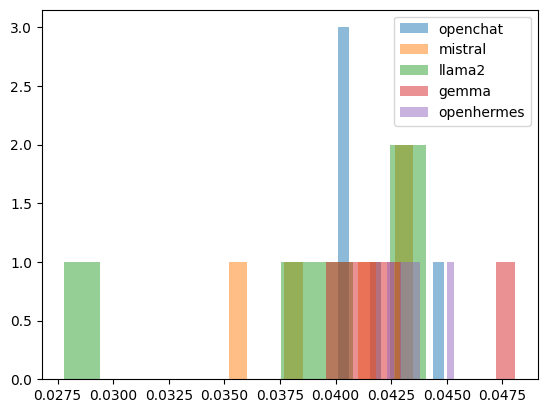

In [7]:
# plot the time per character distribution for each model
import matplotlib.pyplot as plt

for model in models:
    plt.hist(time_df[time_df["model"] == model]["time_per_char"], bins=10, alpha=0.5, label=model)
plt.legend()
plt.show()

### Quality